### In this notebook you will see the simple option of the script and the method how strategy works

Vladimir Saraikin, 2021

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use('seaborn') 

In [2]:
start = '2021-11-15'
end = '2021-12-15'
ticker1 = 'BTC-USD'
ticker2 = 'ETH-USD'
zscore = 0.5

In [3]:
data = yf.download([ticker1, ticker2], start, end, interval='15m')['Adj Close']
data

[*********************100%***********************]  2 of 2 completed


,BTC-USD,ETH-USD
Datetime,,
2021-11-14 21:00:00+00:00,64204.425781,4554.166016
2021-11-14 21:15:00+00:00,64108.257812,4552.740234
2021-11-14 21:30:00+00:00,64441.492188,4589.909180
2021-11-14 21:45:00+00:00,64363.031250,4576.222656
2021-11-14 22:00:00+00:00,64514.230469,4584.045410
...,...,...
2021-12-14 19:45:00+00:00,46923.234375,3776.720215
2021-12-14 20:00:00+00:00,47043.347656,3785.068359
2021-12-14 20:15:00+00:00,47146.972656,3794.128174


### Trading conditions

IF Z-SCORE < -1 then BUY ORDER IS EXECUTED:
<br>    - buy larger coin (btc) and sell small one (eth) * ratio[-1]
<br><br>
IF Z-SCORE > 1 then SELL ORDER IS EXECUTED:
<br>    - sell larger coin (btc) and buy small one (eth) * ratio[-1]


Z-score calculation:
1. ratio = price_series1/price_series2
2. create SMA-5 of ratio, SMA-60 of ratio
3. std60 = ratio.rolling(60).std()
4. zscore = (sma5-sma60)/std60

Fees are not included!

Считаем наши ratio:

In [4]:
ratios_df = pd.DataFrame(columns=['Ratio', '5d Ratio MA', '60d Ratio MA'])
ratios_df.Ratio = data[ticker1] / data[ticker2]

ratios_df['5d Ratio MA'] = ratios_df.Ratio.rolling(window=5, center=False).mean()
ratios_df['60d Ratio MA'] = ratios_df.Ratio.rolling(window=60, center=False).mean()
ratios_df['std_60'] = ratios_df.Ratio.rolling(window=60, center=False).std()

ratios_df['zscore_60_5'] = (ratios_df['5d Ratio MA'] - ratios_df['60d Ratio MA'])/ratios_df['std_60']
ratios_df

,Ratio,5d Ratio MA,60d Ratio MA,std_60,zscore_60_5
Datetime,,,,,
2021-11-14 21:00:00+00:00,14.097955,NaN,NaN,NaN,NaN
2021-11-14 21:15:00+00:00,14.081247,NaN,NaN,NaN,NaN
2021-11-14 21:30:00+00:00,14.039819,NaN,NaN,NaN,NaN
2021-11-14 21:45:00+00:00,14.064663,NaN,NaN,NaN,NaN
2021-11-14 22:00:00+00:00,14.073646,14.071466,NaN,NaN,NaN
...,...,...,...,...,...
2021-12-14 19:45:00+00:00,12.424334,12.444841,12.430892,0.041369,0.337167
2021-12-14 20:00:00+00:00,12.428665,12.441540,12.430370,0.041192,0.271184
2021-12-14 20:15:00+00:00,12.426299,12.436303,12.429785,0.040993,0.159011


Filtering if z-score is less or more than target value

Теперь необходимо аккумулировать все наши сигналы, когда zscore > целевого значения or zscore < -целевого значения

In [5]:
signals = pd.DataFrame(columns=['buy', 'sell'], index = ratios_df.index)
signals['buy'] = np.where(ratios_df.zscore_60_5 < -zscore, -1, 0)
signals['sell'] = np.where(ratios_df.zscore_60_5 > zscore, 1, 0)

In [6]:
signals.sum()

buy    -1155
sell     984
dtype: int64

<AxesSubplot:xlabel='Datetime'>

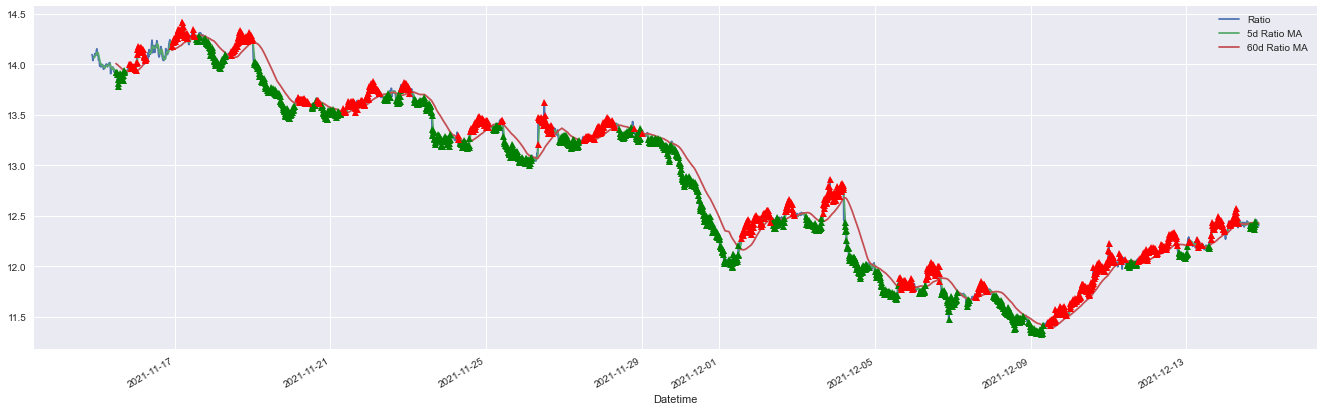

In [7]:
ratios_df[['Ratio', '5d Ratio MA', '60d Ratio MA']].plot(figsize=(23,7))
ratios_df.Ratio[signals.buy != 0].plot(color='g', linestyle='None', marker='^')
ratios_df.Ratio[signals.sell != 0].plot(color='r', linestyle='None', marker='^')

As you see we have got a pyramid consisting of 500+ orders, because z-score can be negative or positive for a long period of time. What we need is following structure: "1 buy" - "1 sell", "1 buy" - "1 sell" etc.

Получается, что у нас более 500 ордеров. Это связано с тем, что zscore может быть отрицательным или положительным длительный период времени - образуется пирамида. Нам же нужно - one by one. Один buy, один sell.

In [8]:
signals = signals[((signals.buy == -1) & (signals.buy.shift(1) == 0)) | ((signals.sell == 1) & (signals.sell.shift(1) == 0))]
signals = signals[(signals.buy.shift(1) != signals.buy) | (signals.sell.shift(1) != signals.sell)]

In [9]:
signals['ratio'] = ratios_df.shift(1)['Ratio']
signals[ticker1] = data[ticker1]
signals[f'{ticker2} * ratio[-1]'] = data[ticker2]
signals[f'{ticker2} * ratio[-1]'] *= signals.ratio

In [10]:
# We check if signals starts with buy order and ends with sell order
if signals.iloc[0]['sell'] > 0:
    signals = signals.iloc[1:]
if signals.iloc[-1]['buy'] < 0:
    signals = signals.iloc[:-1]

In [11]:
profit = {}
stop_loss = -signals[ticker1].iloc[0] * 0.005

# Running strategy
for index_row in signals.index:
    # If strategy is start with buy order => ok, else drop the first row and start with buy order
    if signals.loc[index_row, 'buy'] == -1:
        buy = signals.loc[index_row, ticker1] - signals.loc[index_row, f'{ticker2} * ratio[-1]']
    elif signals.loc[index_row, 'sell'] == 1:
        sell = signals.loc[index_row, f'{ticker2} * ratio[-1]'] - signals.loc[index_row, ticker1]
        profit[index_row] = sell - buy  

# Stop-loss implentation
for key in profit:
    if profit[key] < 0:
        profit[key] = stop_loss

print('Total profit:', sum(profit.values()), 
        'or', 
        f'{((sum(profit.values())/signals.iloc[0,-2])*100).round(2)}%')
print('Amount of orders:', len(profit))

Total profit: -782.5624221507189 or -1.19%
Amount of orders: 23


Profit per one trade = SELL signal - BUY signal, where:
<br>
- buy signal = 1BTC - 1ETH * ratio[-1]
<br>
- sell signal = 1ETH * ratio[-1] - 1BTC

Enter & Exit points

In [12]:
signals

,buy,sell,ratio,BTC-USD,ETH-USD * ratio[-1]
Datetime,,,,,
2021-11-15 11:45:00+00:00,-1,0,13.923121,65776.875000,65786.914418
2021-11-15 20:00:00+00:00,0,1,13.971851,64059.675781,63915.207738
2021-11-17 13:15:00+00:00,-1,0,14.262481,60350.746094,60404.107001
2021-11-18 10:45:00+00:00,0,1,14.118037,59809.554688,59906.973382
2021-11-19 00:45:00+00:00,-1,0,14.056670,57518.625000,57647.809539
2021-11-20 03:45:00+00:00,0,1,13.664047,58502.929688,58478.792428
2021-11-20 12:30:00+00:00,-1,0,13.562593,58597.523438,58561.799516
2021-11-20 16:00:00+00:00,0,1,13.665794,57577.363281,57638.167637
2021-11-20 18:30:00+00:00,-1,0,13.573635,59528.871094,59490.908949


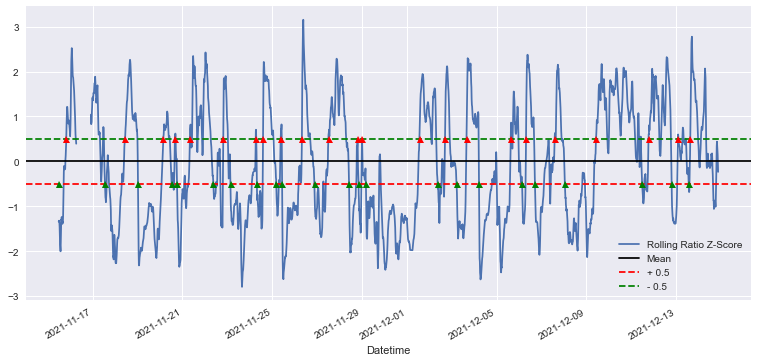

In [13]:
signals.buy = np.where(signals.buy == -1, -zscore, np.where(signals.buy == 0, np.nan, signals.buy))
signals.sell = np.where(signals.sell == 1, zscore, np.where(signals.sell == 0, np.nan, signals.sell))
ratios_df['zscore_60_5'].plot(figsize=(13, 6), legend=True)
plt.axhline(0, color='black')
plt.axhline(-zscore, color='red', linestyle='--')
plt.axhline(zscore, color='green', linestyle='--')
plt.legend(['Rolling Ratio Z-Score', 'Mean', f'+ {zscore}', f'- {zscore}'])
signals['buy'].plot(color='g', linestyle='None', marker='^')
signals['sell'].plot(color='r', linestyle='None', marker='^')
plt.show()

In [14]:
signals.sum().apply(int)

buy                        -11
sell                        11
ratio                      595
BTC-USD                2525162
ETH-USD * ratio[-1]    2525709
dtype: int64

Let's plot distribution of our returns

<AxesSubplot:ylabel='Frequency'>

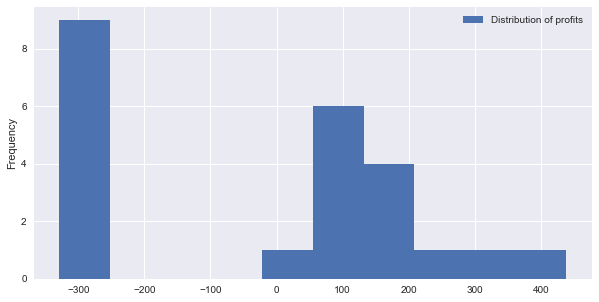

In [15]:
pd.Series(data=profit, name='Distribution of profits').plot.hist(figsize=(10, 5), bins=10, legend=True)